In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

In [ ]:
from datetime import datetime
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


In [ ]:
s = datetime(2015, 1, 1)
e = datetime(2024,12, 31)
data = pdr.get_data_yahoo('005930.KS', s, e)
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,26800.0,26800.0,26540.0,26600.0,21257.931641,8774950
2015-01-05,26720.0,26720.0,26260.0,26660.0,21305.880859,10139500
2015-01-06,26300.0,26340.0,25760.0,25900.0,20698.511719,15235500
2015-01-07,25880.0,26220.0,25640.0,26140.0,20890.312500,14322750
2015-01-08,26780.0,26780.0,26200.0,26280.0,21002.201172,14477600
...,...,...,...,...,...,...
2024-07-12,85900.0,86100.0,84100.0,84400.0,84400.000000,26344386
2024-07-15,84700.0,87300.0,84100.0,86700.0,86700.000000,25193080
2024-07-16,86900.0,88000.0,86700.0,87700.0,87700.000000,16166688


In [ ]:
'''
# 데이터셋 로드
# https://finance.yahoo.com
# https://coinmarketcap.com
#data = pd.read_csv('/content/drive/MyDrive/data/005930.KS_5y.csv')
data = pd.read_csv('./samsung.csv')
data.head()
'''

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,39400.0,39400.0,38550.0,38750.0,33623.347656,7847664
1,2019-01-03,38300.0,38550.0,37450.0,37600.0,32625.490234,12471493
2,2019-01-04,37450.0,37600.0,36850.0,37450.0,32495.349609,14108958
3,2019-01-07,38000.0,38900.0,37800.0,38750.0,33623.347656,12748997
4,2019-01-08,38000.0,39200.0,37950.0,38100.0,33059.351562,12756554


In [ ]:
#data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1341,2024-06-14,79700.0,80500.0,79000.0,79600.0,79600.0,22926612
1342,2024-06-17,79200.0,79500.0,78000.0,78100.0,78100.0,16123051
1343,2024-06-18,78700.0,80200.0,78600.0,79800.0,79800.0,18207598
1344,2024-06-19,81100.0,82500.0,80500.0,81200.0,81200.0,24168863
1345,2024-06-20,81500.0,82200.0,81200.0,81600.0,81600.0,20288913


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2346 entries, 2015-01-02 to 2024-07-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2346 non-null   float64
 1   High       2346 non-null   float64
 2   Low        2346 non-null   float64
 3   Close      2346 non-null   float64
 4   Adj Close  2346 non-null   float64
 5   Volume     2346 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 128.3 KB


In [ ]:
# Compute mid price
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

In [ ]:
# Create Windows
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [ ]:
# Normalization
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train) #섞기

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((2066, 50, 1), (229, 50, 1))

In [ ]:
# Build Model
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear')) # 다음날 하루 예측
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 39905 (155.88 KB)
Trainable params: 39905 (155.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 학습
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)

Epoch 1/20
207/207 [==============================] - 14s 45ms/step - loss: 0.0017 - val_loss: 8.8285e-04
Epoch 2/20
207/207 [==============================] - 8s 37ms/step - loss: 9.2804e-04 - val_loss: 6.7813e-04
Epoch 3/20
207/207 [==============================] - 9s 43ms/step - loss: 8.0576e-04 - val_loss: 6.2229e-04
Epoch 4/20
207/207 [==============================] - 8s 37ms/step - loss: 7.1034e-04 - val_loss: 5.3641e-04
Epoch 5/20
207/207 [==============================] - 9s 43ms/step - loss: 6.5698e-04 - val_loss: 5.6675e-04
Epoch 6/20
207/207 [==============================] - 9s 44ms/step - loss: 6.1161e-04 - val_loss: 4.2003e-04
Epoch 7/20
207/207 [==============================] - 9s 43ms/step - loss: 5.8377e-04 - val_loss: 4.3249e-04
Epoch 8/20
207/207 [==============================] - 8s 40ms/step - loss: 5.5440e-04 - val_loss: 4.6016e-04
Epoch 9/20
207/207 [==============================] - 9s 42ms/step - loss: 5.3203e-04 - val_loss: 3.3988e-04
Epoch 10/20
207/207 [=

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 1s 20ms/step


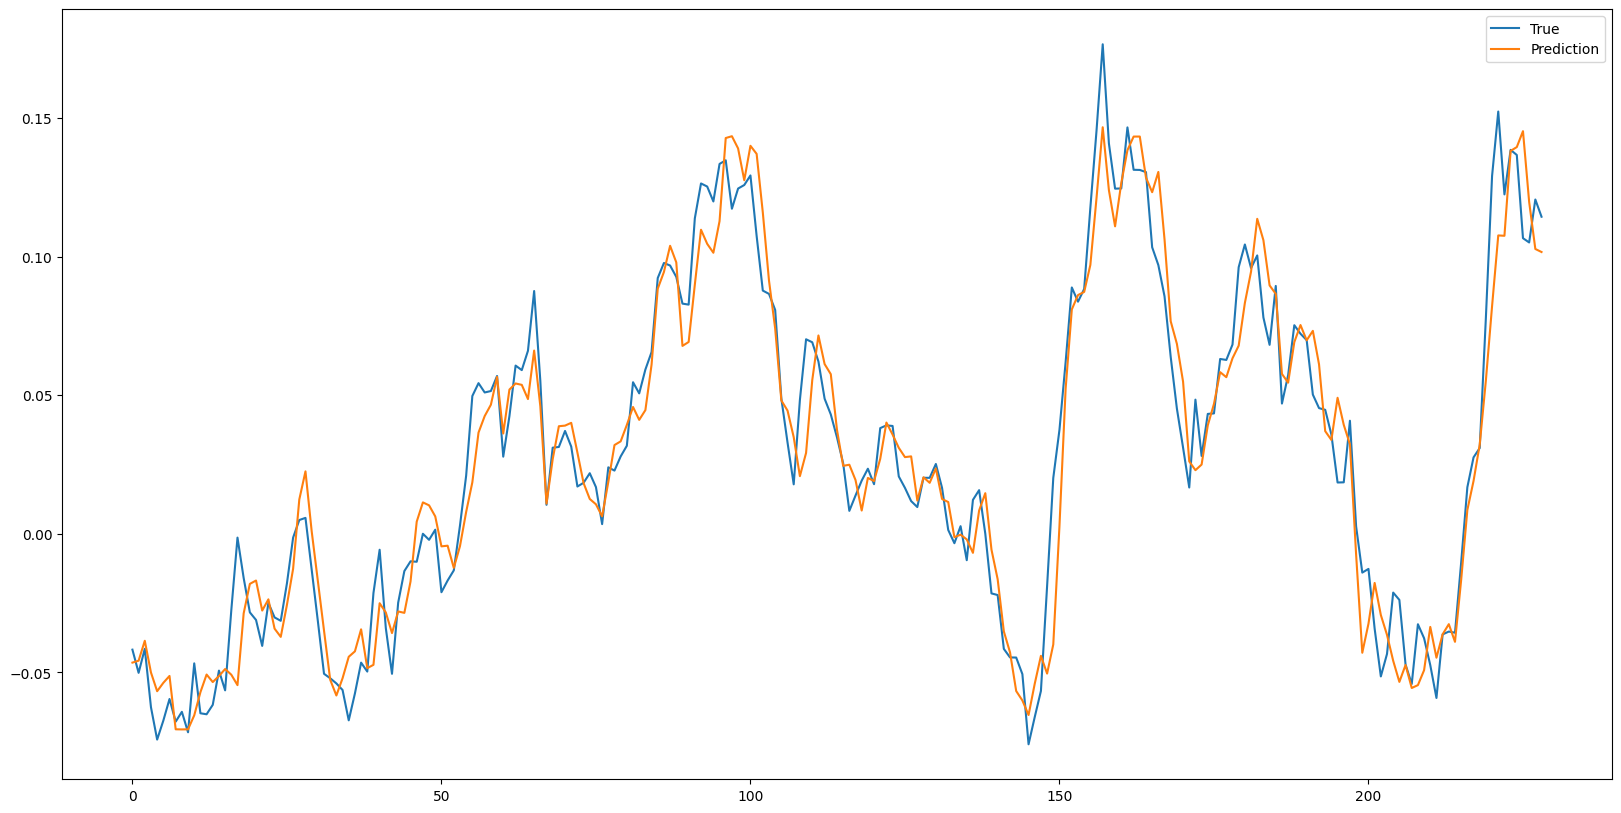

In [ ]:
# 예측
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

1/1 [==============================] - 0s 27ms/step


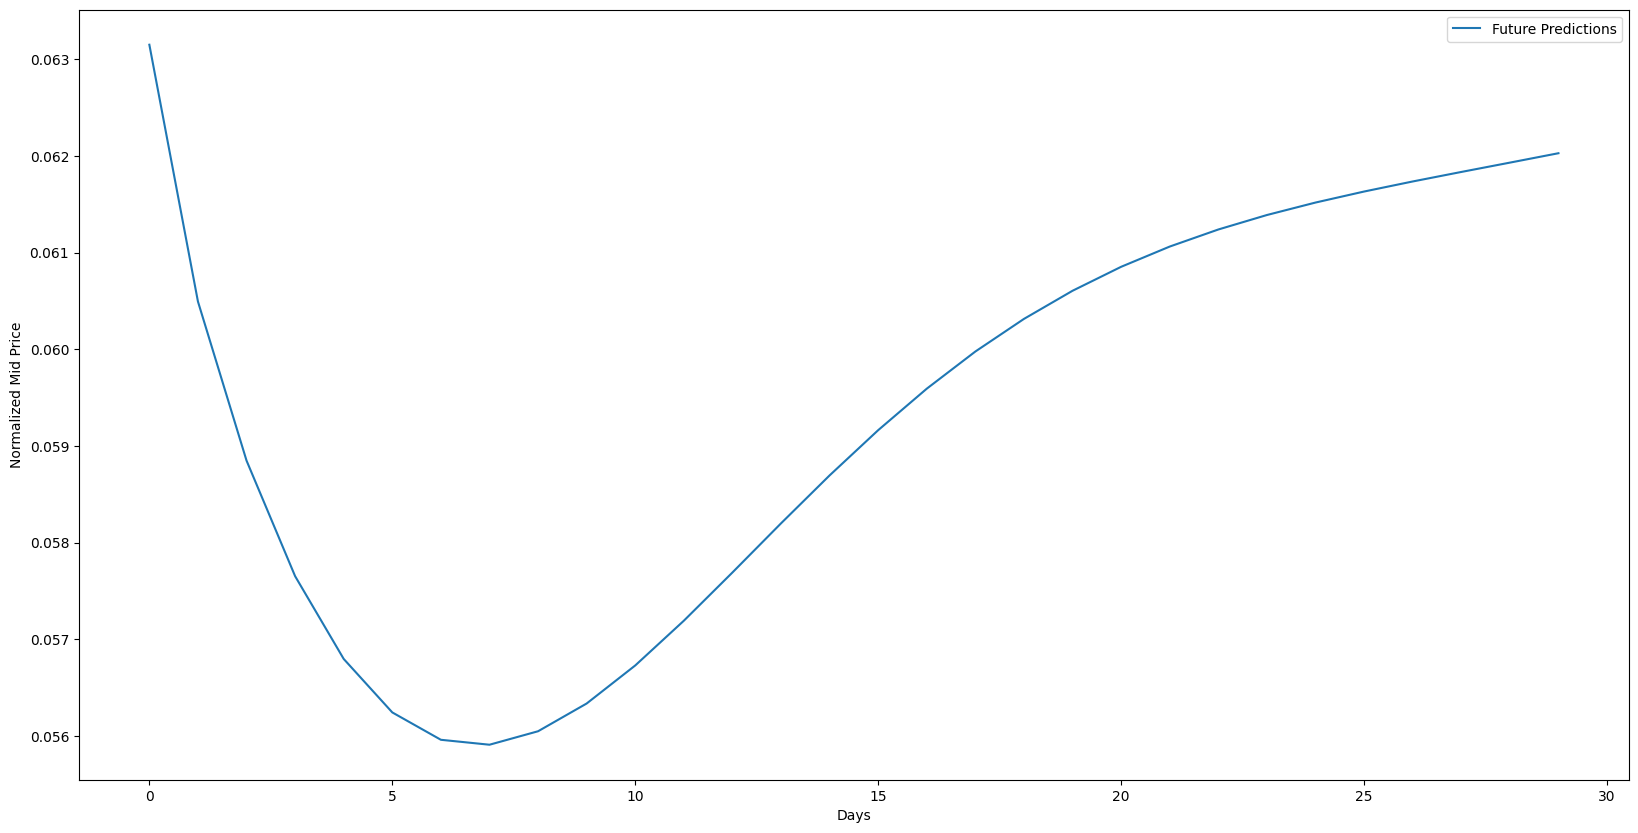

In [ ]:
# 최근 데이터로부터 50일치 시퀀스를 가져옵니다
# normalized_data는 시퀀스 단위 리스트였으므로, 이를 바로 사용하면 안됩니다.
recent_data = mid_prices[-50:]  # 직접 mid_prices에서 추출

# 데이터 노말라이즈 (Normalize recent data)
normalized_recent_data = [((float(p) / float(recent_data[0])) - 1) for p in recent_data]

# 리셰이프하여 모델의 입력 형태로 변환
current_sequence = np.array(normalized_recent_data).reshape((1, 50, 1))

# 예측할 날의 수
predict_days = 30
predictions = []

for _ in range(predict_days):
    next_prediction = model.predict(current_sequence)
    next_prediction = np.array(next_prediction).reshape((1, 1, 1))
    predictions.append(next_prediction[0, 0, 0])

    # 새로운 시퀀스 업데이트
    new_sequence = np.append(current_sequence[:, 1:, :], next_prediction, axis=1)
    current_sequence = new_sequence

# 예측 결과 플롯팅
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(predictions, label='Future Predictions')
ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Normalized Mid Price')
plt.show()

8/8 [==============================] - 0s 15ms/step
Base Price for Test Set: 71100.0


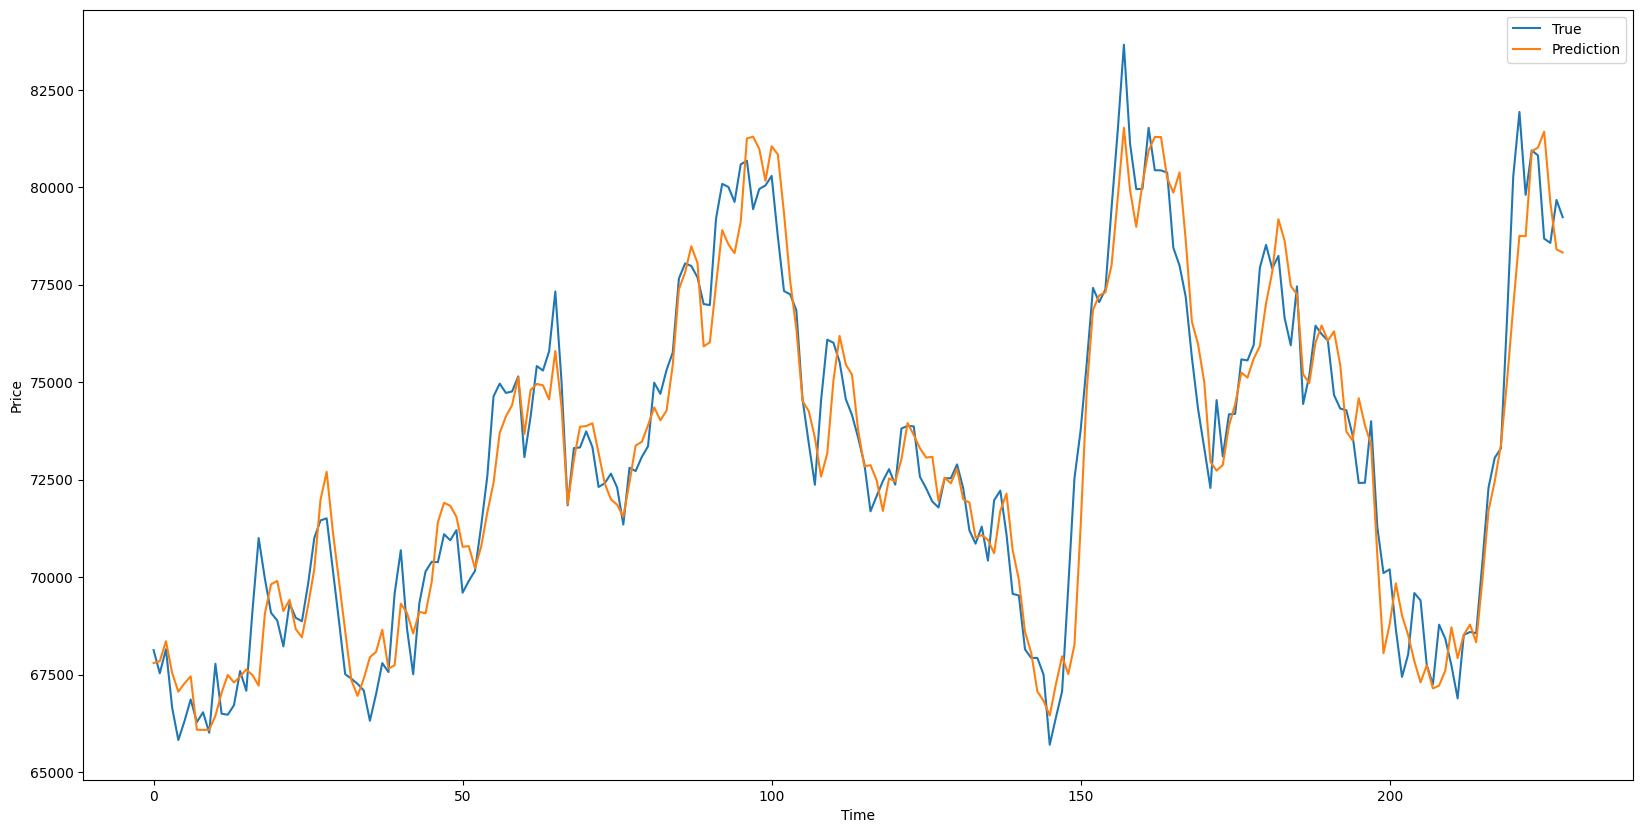

1/1 [==============================] - 0s 25ms/step


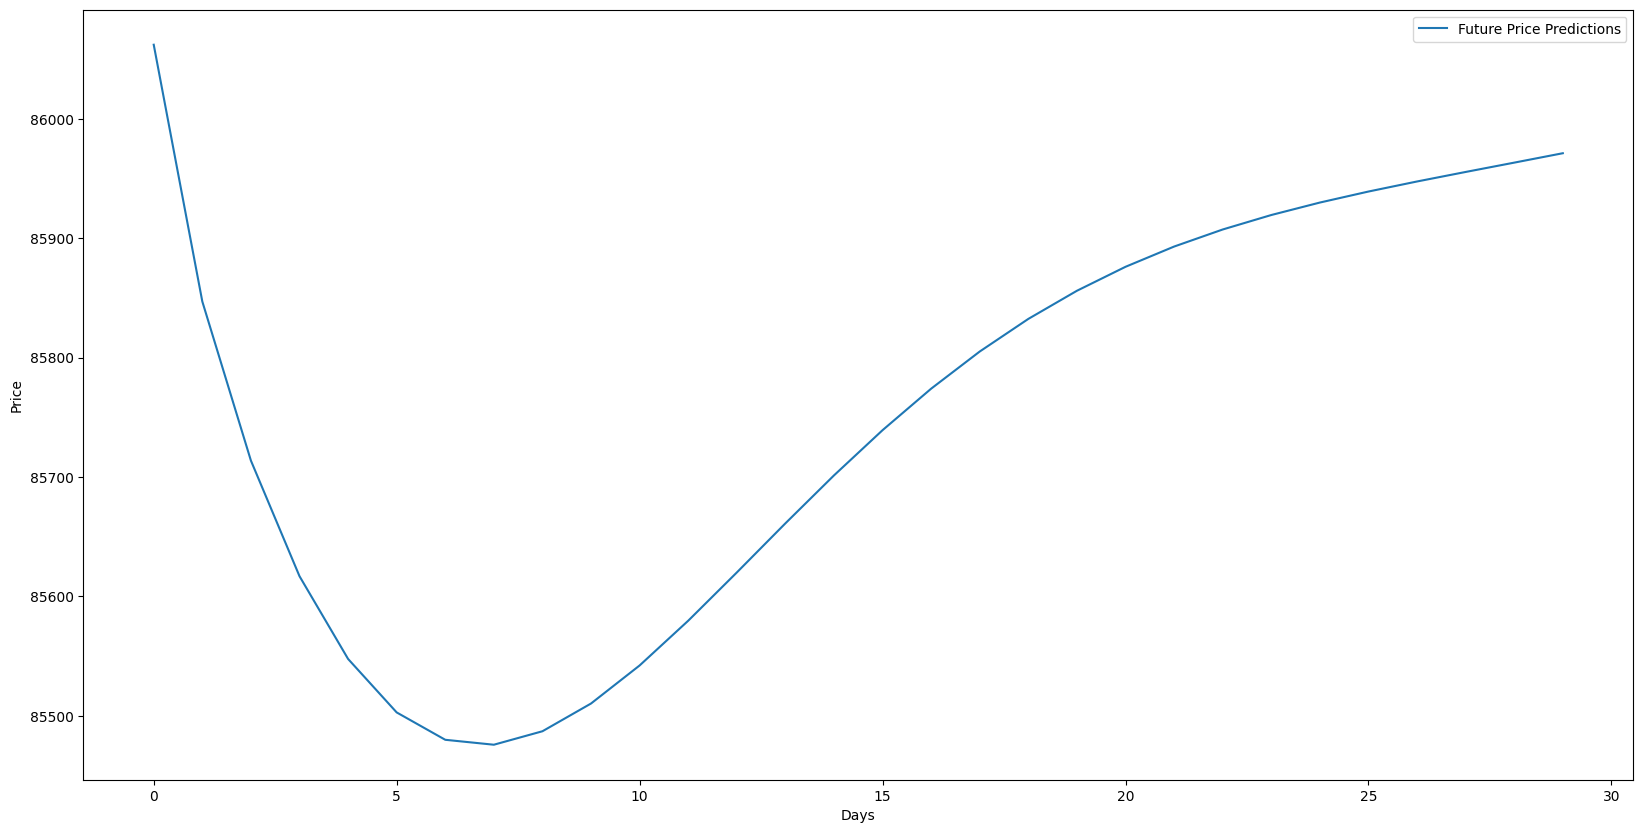

In [ ]:
# 예측 수행
pred = model.predict(x_test)

# 기준 값: x_test에서 첫 번째 시퀀스의 첫 번째 값의 실제 가격
base_price_test = mid_prices[-len(y_test) - seq_len + 1: -len(y_test) + 1][0]

# 실제 값과 예측 값을 원래의 가격으로 변환
y_test_price = (y_test + 1) * base_price_test
pred_price = (pred.flatten() + 1) * base_price_test

print("Base Price for Test Set:", base_price_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test_price, label='True')
ax.plot(pred_price, label='Prediction')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Price')
plt.show()

# -- 미래 값을 예측하여 가격으로 변환 --
# 최근 데이터로부터 50일치 시퀀스를 가져옵니다
recent_data = mid_prices[-50:]  # 직접 mid_prices에서 추출

# 데이터 노말라이즈 (Normalize recent data)
normalized_recent_data = [((float(p) / float(recent_data[0])) - 1) for p in recent_data]

# 리셰이프하여 모델의 입력 형태로 변환
current_sequence = np.array(normalized_recent_data).reshape((1, 50, 1))

# 예측할 날의 수
predict_days = 30
predictions = []

for _ in range(predict_days):
    next_prediction = model.predict(current_sequence)

    # 모델의 출력인 next_prediction을 (1, 1, 1) 형식의 배열로 변환
    next_prediction = np.array(next_prediction).reshape((1, 1, 1))

    predictions.append(next_prediction[0, 0, 0])

    # 새로운 시퀀스 업데이트
    current_sequence = np.append(current_sequence[:, 1:, :], next_prediction, axis=1)

# 노말라이즈된 예측 값을 실제 가격으로 변환
predicted_prices = [(p + 1) * recent_data[0] for p in predictions]

# 예측 결과 플롯팅
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(predicted_prices, label='Future Price Predictions')
ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Price')
plt.show()